# AI6126 ACV Project 1


In [1]:
nb_ver = 0.91
title = f'ai6126-project1-colab-v{nb_ver}'
print(title)
comments = "albuv2"
print(comments)

ai6126-project1-colab-v0.91
albuv2


## Versioning & References

### Changelogs
+ V0.1 - Setup codes to download and unzip celeba to gDrive
+ V0.2 - Added training loop 
+ V0.3 - Added seeding + save/ load checkpoint
+ V0.4 - Added time taken + save output
+ V0.5 - Added RandomErasing to transforms
+ V0.6 - Added get_criterion (BinaryFocalLoss) - NOT WORKING YET
+ V0.7 - Added FaceAttrMobileNetV2 & FaceAttrResNeXt
+ V0.8 - Added Albumentations
+ V0.9 - Updated Optimizer
+ V0.91 - Added ModelTimer() + Added more augmentations

### References
+ [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

### Dependencies

In [2]:
# conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
# conda install matplotlib
# conda install pandas
# conda install tqdm
# conda install -c conda-forge jupyterlab
# conda install -c conda-forge tensorboard
# conda install -c conda-forge protobuf # for tensorboard
# conda install nb_conda_kernels # auto add kernels

# conda install -c conda-forge imgaug
# conda install albumentations -c conda-forge

## Setup/ Configuration

### Colab

In [3]:
# you can choose to mount your Google Drive (optional)
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    file_name = f'ai6126-project1-colab-v{nb_ver}.ipynb'
    print(file_name)
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

In [4]:
# check nvcc version
!nvcc -V
# check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:12:52_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.1, V10.1.243


'gcc' is not recognized as an internal or external command,
operable program or batch file.


### Download Dataset

In [5]:
import os, glob
local_download_path = '../data/celeba/img_align_celeba'
download_dataset = True
if os.path.exists(local_download_path):
    images = glob.glob(local_download_path + '/*.jpg')
    if len(images) == 202599:
        download_dataset = False
print(f"download celeba dataset: {download_dataset}")

if download_dataset:
    # create dataset root and enter it
    !mkdir -p data/celeba
    %cd data/celeba

    # we have prepared a backup of `img_align_celeba.zip` of Celeb-A dataset in the Dropbox
    # download it directly, or manually download the original file from Google Drive above
    !wget https://www.dropbox.com/s/8kzo40fqx7nodat/img_align_celeba.zip

    # unzip the downloaded file
    !unzip -qq img_align_celeba.zip
    !rm -f img_align_celeba.zip

    # change the directory back to the root
    %cd ../..
    !ls

download celeba dataset: False


## Implementation

### Imports

In [6]:
import sys, os
import time
import random
import numpy as np
import copy
from datetime import datetime
from distutils.dir_util import copy_tree #for recursive filecopying

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from tqdm import tqdm
import matplotlib.pyplot as plt

import config
from celeba_dataset import CelebaDataset
import models
import losses
from utils import Logger, AverageMeter, Bar, savefig, adjust_learning_rate, accuracy, reset_gpu_cache, print_attribute_acc, create_dir_ifne, ModelTimer

In [7]:
# set the backend of matplotlib to the 'inline' backend
%matplotlib inline

# check PyTorch version and cuda status
print(torch.__version__, torch.cuda.is_available())

# define device
device = torch.device("cuda:"+config.gpu_id if torch.cuda.is_available() else "cpu")
print(device)

if 'ipykernel' in sys.modules:
    config.disable_tqdm = False
print(f"disable_tqdm: {config.disable_tqdm}")

1.6.0 True
cuda:0
disable_tqdm: False


### Seeding

In [8]:
# set random seed for reproducibility
def seed_everything(seed=None):
    if seed is None:
        seed = random.randint(1, 10000) # create random seed
        print(f'random seed used: {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    if 'torch' in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config.manual_seed)

### Data Transform

In [9]:
# attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
#                    'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
#                    'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
#                    'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
#                    'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
#                    'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
#                    'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
# print(attribute_names)

In [10]:
# Data augmentation and normalization for training
# Just normalization for validation and testing

def load_dataloaders(print_info=True, albu_transforms = True):
    if config.evaluate:
        phases = ['test']
    else:
        phases = ['train', 'val']

    attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
    
    attributes_list = {
        'train': config.TRAIN_ATTRIBUTE_LIST,
        'val': config.VAL_ATTRIBUTE_LIST,
        'test': config.TEST_ATTRIBUTE_LIST
    }

    batch_sizes = {
        'train': config.train_batch,
        'val': config.test_batch,
        'test': config.test_batch
    }

    if not albu_transforms:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(128), #new
                transforms.CenterCrop(128), #new
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10), #new
                transforms.ToTensor(),
                normalize,
                transforms.RandomErasing()
            ]),
            'val': transforms.Compose([
                transforms.Resize(128), #new
                transforms.ToTensor(),
                normalize
            ]),
            'test': transforms.Compose([
                transforms.Resize(128), #new
                transforms.ToTensor(),
                normalize
            ])
        }
    else:
        normalize_A = A.Normalize(mean=(0.485, 0.456, 0.406), 
                                  std=(0.229, 0.224, 0.225))
        data_transforms = {
            'train': A.Compose(
            [
                A.SmallestMaxSize(max_size=160),
                #A.RandomCrop(width=148, height=148),
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                                  rotate_limit=15, p=0.5),
                A.FancyPCA(p=0.5), #http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
                A.GaussNoise(var_limit=(10.0, 80.0), p=0.5),
                A.GaussianBlur(p=0.2),
                A.RandomBrightnessContrast(p=0.5),
                A.CoarseDropout(),
                normalize_A,
                ToTensorV2(),
                
            ]),
            'val': A.Compose([
                    A.SmallestMaxSize(max_size=160),
                    #A.CenterCrop(height=148, width=148),
                    normalize_A,
                    ToTensorV2(),
            ]
            ),
            'test': A.Compose([
                A.SmallestMaxSize(max_size=160),
                #A.CenterCrop(height=148, width=148),
                normalize_A,
                ToTensorV2(),
            ])
        }

    image_datasets = {x: CelebaDataset(config.IMG_DIR, attributes_list[x], 
                                       data_transforms[x]) 
                      for x in phases}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=batch_sizes[x],
                                                  pin_memory=True, shuffle=(x == 'train'), 
                                                  num_workers=config.dl_workers) 
                   for x in phases}
    if print_info:
        dataset_sizes = {x: len(image_datasets[x]) for x in phases}
        print(f"Dataset sizes: {dataset_sizes}")
        
    if config.evaluate:
        class_names = image_datasets['test'].targets
    else:
        class_names = image_datasets['train'].targets
    print(f"Class Labels: {len(class_names[0])}")
    assert len(attribute_names) == len(class_names[0])
    return dataloaders, attribute_names

### Model Architecture Initialization

In [11]:
model_names = sorted(name for name in models.__dict__
                     if callable(models.__dict__[name])) # and name.islower() and not name.startswith("__"))
print(f"Available Models: {model_names}")

Available Models: ['FaceAttrMobileNetV2', 'FaceAttrResNeXt', 'FaceAttrResNet']


In [12]:
def create_model(device):
    print("=> creating model '{}'".format(config.arch))
    if config.arch.startswith('FaceAttrResNet'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    elif config.arch.startswith('FaceAttrResNeXt'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    elif config.arch.startswith('FaceAttrMobileNetV2'):
        model = models.__dict__[config.arch]()
    #print(model)
    model = model.to(device)
    return model
#print(model)
model = create_model(device)

=> creating model 'FaceAttrResNet'


### Criterion & Optimizer

In [13]:
def get_criterion():
    criterion = nn.CrossEntropyLoss().to(device)
    if config.criterion == 'BinaryFocalLoss':
        criterion = losses.BinaryFocalLoss().to(device)
    elif config.criterion == 'FocalLoss':
        criterion = losses.FocalLoss(alpha=0.25, gamma=5, reduction='mean').to(device)
    return criterion

criterion = get_criterion()

In [14]:
def get_optimizer(model):
    optimizer = torch.optim.SGD(model.parameters(), config.lr,
                            momentum=config.momentum,
                            weight_decay=config.weight_decay)
    if config.optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), config.lr,
                            weight_decay=config.weight_decay)
    elif config.optimizer == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), config.lr,
                            weight_decay=config.weight_decay)
    return optimizer

optimizer = get_optimizer(model)

### Resume Checkpoint if any

In [15]:
def resume_checkpoint(model, optimizer, ckp_logger_fname, ckp_resume=None):
    if not os.path.isdir(config.CHECKPOINT_DIR):
        try: 
            os.makedirs(config.CHECKPOINT_DIR)
        except OSError:
            raise
            
    start_epoch = 0
    best_prec1 = 0
    lr = config.lr

    if ckp_resume and os.path.isfile(ckp_resume): 
        print(f"=> resuming model: {ckp_resume}")
        optimizer, start_epoch, best_prec1, lr, total_train_time = model.load_ckp(optimizer, ckp_resume)
        model_timer = ModelTimer(total_train_time)
        if config.scheduler == 'Manual':
            lr = config.lr # self adjust from original
        config.checkpoint = os.path.dirname(ckp_resume)
        logger = Logger(ckp_logger_fname, title=model.name, resume=True)
    else:
        model_timer = ModelTimer()
        logger = Logger(ckp_logger_fname, title=model.name)
        logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])
        
        
    return best_prec1, model_timer, lr, start_epoch, logger

best_prec1, mt, lr, start_epoch, logger = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.ckp_resume)
print(f"=> Model trained time: {mt}")

=> Model trained time: 00:00:00


## Train & Validate Function

In [16]:
def train(train_loader, model, criterion, optimizer):
    bar = Bar('Processing', max=len(train_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to train mode
    model.train()

    end = time.time()
    for i, (X, y) in enumerate(tqdm(train_loader, disable=config.disable_tqdm)):
        # measure data loading time
        data_time.update(time.time() - end)

        # Overlapping transfer if pinned memory
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
    
        # compute output
        output = model(X)
        # measure accuracy and record loss
        loss = []
        prec1 = []
        for j in range(len(output)): 
            # output[j]: [N,C] y[:,j]:[N]
            # CE Criterion: [] scalar
#             print("output s: ", output[j].shape)
#             print("output y: ", y[:, j].shape)
            crit = criterion(output[j], y[:, j])
#             print(crit.detach())
            loss.append(crit)
            prec1.append(accuracy(output[j], y[:, j], topk=(1,)))
            losses[j].update(loss[j].detach().item(), X.size(0))
            top1[j].update(prec1[j][0].item(), X.size(0))
            
        losses_avg = [losses[k].avg for k in range(len(losses))]
        top1_avg = [top1[k].avg for k in range(len(top1))]
        loss_avg = sum(losses_avg) / len(losses_avg)
        prec1_avg = sum(top1_avg) / len(top1_avg)

        # compute gradient and do optimizer step
        optimizer.zero_grad()
        loss_sum = sum(loss)
        loss_sum.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                        batch=i + 1,
                        size=len(train_loader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=loss_avg,
                        top1=prec1_avg,
                        )
        if not config.disable_tqdm and (i+1)% 100 == 0:
            print(print_line)
        bar.suffix  = print_line
        bar.next()
    bar.finish()
    return (loss_avg, prec1_avg)

In [17]:
def validate(val_loader, model, criterion):
    bar = Bar('Processing', max=len(val_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (X, y) in enumerate(tqdm(val_loader, disable=config.disable_tqdm)):
            # measure data loading time
            data_time.update(time.time() - end)

            # Overlapping transfer if pinned memory
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # compute output
            output = model(X)
            # measure accuracy and record loss
            loss = []
            prec1 = []
            for j in range(len(output)):
                loss.append(criterion(output[j], y[:, j]))
                prec1.append(accuracy(output[j], y[:, j], topk=(1,)))
                
                losses[j].update(loss[j].detach().item(), X.size(0))
                top1[j].update(prec1[j][0].item(), X.size(0))
            losses_avg = [losses[k].avg for k in range(len(losses))]
            top1_avg = [top1[k].avg for k in range(len(top1))]
            loss_avg = sum(losses_avg) / len(losses_avg)
            prec1_avg = sum(top1_avg) / len(top1_avg)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            
            # plot progress
            print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                            batch=i + 1,
                            size=len(val_loader),
                            data=data_time.avg,
                            bt=batch_time.avg,
                            total=bar.elapsed_td,
                            eta=bar.eta_td,
                            loss=loss_avg,
                            top1=prec1_avg,
                            )

            bar.suffix  = print_line
            bar.next()  

    if not config.disable_tqdm:
        print(print_line)        
    bar.finish()
    return (loss_avg, prec1_avg, top1)

## Main Function

In [18]:
def trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name, model_timer):
    # visualization
    writer = SummaryWriter(os.path.join(config.tensorboard_dir, run_name))
    
    for epoch in range(start_epoch, config.epochs):
        model_timer.start_epoch_timer()
        lr = adjust_learning_rate(optimizer, config.lr_decay, epoch, gamma=config.gamma, step=config.step,
                                 total_epochs=config.epochs, turning_point=config.turning_point,
                                 schedule=config.schedule)

        print('\nEpoch: [%d | %d] LR: %.16f' % (epoch + 1, config.epochs, lr))

        # train for one epoch
        train_loss, train_acc = train(dataloaders['train'], model, criterion, optimizer)

        # evaluate on validation set
        val_loss, prec1, _ = validate(dataloaders['val'], model, criterion)

        # append logger file
        logger.append([lr, train_loss, val_loss, train_acc, prec1])

        # tensorboardX
        writer.add_scalar('learning rate', lr, epoch + 1)
        writer.add_scalars('loss', {'train loss': train_loss, 'validation loss': val_loss}, epoch + 1)
        writer.add_scalars('accuracy', {'train accuracy': train_acc, 'validation accuracy': prec1}, epoch + 1)
        #for name, param in model.named_parameters():
        #    writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch + 1)

        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        model_timer.stop_epoch_timer()
        model.save_ckp({
            'epoch': epoch + 1,
            'arch': model.name,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
            'lr': lr,
            'total_time': model_timer.total_time
        }, is_best, config.checkpoint_fname,config.bestmodel_fname)

    logger.close()
    logger.plot()
    savefig(config.train_plotfig)
    writer.close()

    print('Best accuracy:')
    print(best_prec1)
    return model_timer

In [19]:
def get_run_name_time(model, criterion, optimizer, comments):
    try:
        if criterion.name:
            p_criterion = criterion.name
    except:
        p_criterion = 'CE'

    p_optimizer = f'{str(optimizer).split("(")[0].strip()}'
    p_scheduler = f'{config.lr_decay}_lr{config.lr}_wd{config.weight_decay}'
    if config.lr_decay == 'step':
        p_scheduler += f'_g{config.gamma}_sp{config.step}'
    elif config.lr_decay == 'linear2exp':
        p_scheduler += f'_g{config.gamma}_tp{config.turning_point}'
    elif config.lr_decay == 'schedule':
        p_scheduler += f'_g{config.gamma}_sch{config.schedule}'

    run_name = f'{model.name}_{config.manual_seed}_s{start_epoch}e{config.epochs}_' \
                + f'tb{config.train_batch}_vb{config.test_batch}_' \
                + f'{p_criterion}_{p_optimizer}_' \
                + f'{comments}_' \
                + f'{p_scheduler}'
    
    run_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    print(run_name, run_time)
    return run_name, run_time

## Training Loop

=> creating model 'FaceAttrResNet'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

Dataset sizes: {'train': 162770, 'val': 19867}
Class Labels: 40
=> Training model: True
FaceAttrResNet18_42_s0e50_tb256_vb128_FL_AdamW_albuv2_step_lr0.01_wd0.0001_g0.1_sp30 20201007_093338

Epoch: [1 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:25<07:09,  1.25it/s]

(100/636) Data: 0.381s | Batch: 0.854s | Total: 0:01:25 | ETA: 0:07:41 | Loss: 0.0132 | top1:  78.3752


 31%|█████████████████████████▏                                                      | 200/636 [02:33<03:43,  1.95it/s]

(200/636) Data: 0.318s | Batch: 0.768s | Total: 0:02:33 | ETA: 0:04:11 | Loss: 0.0115 | top1:  79.1866


 47%|█████████████████████████████████████▋                                          | 300/636 [03:42<03:35,  1.56it/s]

(300/636) Data: 0.302s | Batch: 0.743s | Total: 0:03:42 | ETA: 0:03:32 | Loss: 0.0102 | top1:  79.5560


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:50<01:59,  1.98it/s]

(400/636) Data: 0.287s | Batch: 0.726s | Total: 0:04:50 | ETA: 0:02:21 | Loss: 0.0094 | top1:  79.7726


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:58<01:32,  1.47it/s]

(500/636) Data: 0.280s | Batch: 0.717s | Total: 0:05:58 | ETA: 0:01:32 | Loss: 0.0089 | top1:  79.9156


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [07:04<00:18,  1.92it/s]

(600/636) Data: 0.269s | Batch: 0.708s | Total: 0:07:04 | ETA: 0:00:24 | Loss: 0.0084 | top1:  79.9816


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.23it/s]


(156/156) Data: 0.050s | Batch: 0.157s | Total: 0:00:24 | ETA: 0:00:01 | Loss: 0.0042 | top1:  80.7370
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [2 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:18,  2.07it/s]

(100/636) Data: 0.121s | Batch: 0.617s | Total: 0:01:01 | ETA: 0:04:20 | Loss: 0.0049 | top1:  80.3880


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:27,  2.10it/s]

(200/636) Data: 0.062s | Batch: 0.548s | Total: 0:01:49 | ETA: 0:03:30 | Loss: 0.0049 | top1:  80.4278


 47%|█████████████████████████████████████▋                                          | 300/636 [02:38<02:40,  2.09it/s]

(300/636) Data: 0.042s | Batch: 0.527s | Total: 0:02:38 | ETA: 0:02:43 | Loss: 0.0047 | top1:  80.4585


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:53,  2.07it/s]

(400/636) Data: 0.032s | Batch: 0.516s | Total: 0:03:26 | ETA: 0:01:55 | Loss: 0.0046 | top1:  80.4569


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:15<01:05,  2.08it/s]

(500/636) Data: 0.026s | Batch: 0.510s | Total: 0:04:15 | ETA: 0:01:07 | Loss: 0.0045 | top1:  80.4528


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:03<00:17,  2.06it/s]

(600/636) Data: 0.022s | Batch: 0.506s | Total: 0:05:03 | ETA: 0:00:18 | Loss: 0.0044 | top1:  80.4708


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.83it/s]


(156/156) Data: 0.050s | Batch: 0.143s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0036 | top1:  80.6643
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [3 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:17,  2.08it/s]

(100/636) Data: 0.123s | Batch: 0.614s | Total: 0:01:01 | ETA: 0:04:18 | Loss: 0.0041 | top1:  80.4623


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:32,  2.06it/s]

(200/636) Data: 0.063s | Batch: 0.548s | Total: 0:01:49 | ETA: 0:03:35 | Loss: 0.0040 | top1:  80.5112


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:46,  2.02it/s]

(300/636) Data: 0.043s | Batch: 0.526s | Total: 0:02:37 | ETA: 0:02:43 | Loss: 0.0041 | top1:  80.4996


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:54,  2.06it/s]

(400/636) Data: 0.032s | Batch: 0.516s | Total: 0:03:26 | ETA: 0:01:56 | Loss: 0.0040 | top1:  80.5018


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:05,  2.09it/s]

(500/636) Data: 0.026s | Batch: 0.509s | Total: 0:04:14 | ETA: 0:01:06 | Loss: 0.0040 | top1:  80.5002


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.11it/s]

(600/636) Data: 0.022s | Batch: 0.504s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0040 | top1:  80.5076


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.83it/s]


(156/156) Data: 0.049s | Batch: 0.143s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0036 | top1:  80.8172
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [4 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:28,  2.00it/s]

(100/636) Data: 0.121s | Batch: 0.615s | Total: 0:01:01 | ETA: 0:04:23 | Loss: 0.0039 | top1:  80.5396


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:30,  2.07it/s]

(200/636) Data: 0.061s | Batch: 0.548s | Total: 0:01:49 | ETA: 0:03:30 | Loss: 0.0038 | top1:  80.5908


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:42,  2.07it/s]

(300/636) Data: 0.042s | Batch: 0.526s | Total: 0:02:37 | ETA: 0:02:43 | Loss: 0.0038 | top1:  80.6053


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:52,  2.10it/s]

(400/636) Data: 0.032s | Batch: 0.515s | Total: 0:03:26 | ETA: 0:01:54 | Loss: 0.0038 | top1:  80.6201


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:05,  2.07it/s]

(500/636) Data: 0.026s | Batch: 0.509s | Total: 0:04:14 | ETA: 0:01:07 | Loss: 0.0038 | top1:  80.5797


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:09<00:18,  1.95it/s]

(600/636) Data: 0.022s | Batch: 0.516s | Total: 0:05:09 | ETA: 0:00:20 | Loss: 0.0038 | top1:  80.5795


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.97it/s]


(156/156) Data: 0.048s | Batch: 0.140s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.0036 | top1:  80.7930
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [5 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:22,  2.04it/s]

(100/636) Data: 0.120s | Batch: 0.612s | Total: 0:01:01 | ETA: 0:04:19 | Loss: 0.0038 | top1:  80.5763


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:31,  2.07it/s]

(200/636) Data: 0.061s | Batch: 0.547s | Total: 0:01:49 | ETA: 0:03:32 | Loss: 0.0038 | top1:  80.6144


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:43,  2.06it/s]

(300/636) Data: 0.041s | Batch: 0.526s | Total: 0:02:37 | ETA: 0:02:44 | Loss: 0.0038 | top1:  80.6719


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:56,  2.02it/s]

(400/636) Data: 0.031s | Batch: 0.515s | Total: 0:03:26 | ETA: 0:01:56 | Loss: 0.0038 | top1:  80.7175


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:05,  2.06it/s]

(500/636) Data: 0.025s | Batch: 0.508s | Total: 0:04:14 | ETA: 0:01:07 | Loss: 0.0038 | top1:  80.7336


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.08it/s]

(600/636) Data: 0.021s | Batch: 0.504s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0038 | top1:  80.7326


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.81it/s]


(156/156) Data: 0.051s | Batch: 0.144s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0036 | top1:  80.8926
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [6 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:17,  2.08it/s]

(100/636) Data: 0.120s | Batch: 0.614s | Total: 0:01:01 | ETA: 0:04:19 | Loss: 0.0037 | top1:  80.8382


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:30,  2.07it/s]

(200/636) Data: 0.061s | Batch: 0.548s | Total: 0:01:49 | ETA: 0:03:31 | Loss: 0.0037 | top1:  80.9728


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:41,  2.08it/s]

(300/636) Data: 0.041s | Batch: 0.526s | Total: 0:02:37 | ETA: 0:02:44 | Loss: 0.0036 | top1:  81.1824


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:54,  2.05it/s]

(400/636) Data: 0.031s | Batch: 0.515s | Total: 0:03:26 | ETA: 0:01:55 | Loss: 0.0036 | top1:  81.3907


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:05,  2.06it/s]

(500/636) Data: 0.025s | Batch: 0.509s | Total: 0:04:14 | ETA: 0:01:06 | Loss: 0.0036 | top1:  81.5644


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.08it/s]

(600/636) Data: 0.021s | Batch: 0.504s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0036 | top1:  81.7420


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.94it/s]


(156/156) Data: 0.049s | Batch: 0.141s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0033 | top1:  82.5044
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [7 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:17,  2.08it/s]

(100/636) Data: 0.119s | Batch: 0.610s | Total: 0:01:01 | ETA: 0:04:21 | Loss: 0.0033 | top1:  83.0471


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:28,  2.09it/s]

(200/636) Data: 0.061s | Batch: 0.547s | Total: 0:01:49 | ETA: 0:03:31 | Loss: 0.0032 | top1:  83.2640


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:41,  2.09it/s]

(300/636) Data: 0.041s | Batch: 0.525s | Total: 0:02:37 | ETA: 0:02:43 | Loss: 0.0032 | top1:  83.3078


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:25<01:53,  2.08it/s]

(400/636) Data: 0.031s | Batch: 0.514s | Total: 0:03:25 | ETA: 0:01:54 | Loss: 0.0032 | top1:  83.3914


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:05,  2.08it/s]

(500/636) Data: 0.025s | Batch: 0.508s | Total: 0:04:14 | ETA: 0:01:07 | Loss: 0.0032 | top1:  83.4848


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.10it/s]

(600/636) Data: 0.021s | Batch: 0.504s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0032 | top1:  83.5555


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.97it/s]


(156/156) Data: 0.049s | Batch: 0.140s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.0032 | top1:  84.0655
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [8 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:20,  2.06it/s]

(100/636) Data: 0.120s | Batch: 0.613s | Total: 0:01:01 | ETA: 0:04:20 | Loss: 0.0030 | top1:  84.3961


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:32,  2.05it/s]

(200/636) Data: 0.061s | Batch: 0.547s | Total: 0:01:49 | ETA: 0:03:30 | Loss: 0.0030 | top1:  84.5028


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:41,  2.08it/s]

(300/636) Data: 0.041s | Batch: 0.526s | Total: 0:02:37 | ETA: 0:02:43 | Loss: 0.0031 | top1:  84.3934


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:25<01:53,  2.07it/s]

(400/636) Data: 0.031s | Batch: 0.515s | Total: 0:03:25 | ETA: 0:01:55 | Loss: 0.0031 | top1:  84.4837


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:05,  2.08it/s]

(500/636) Data: 0.025s | Batch: 0.508s | Total: 0:04:14 | ETA: 0:01:06 | Loss: 0.0030 | top1:  84.7001


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.08it/s]

(600/636) Data: 0.021s | Batch: 0.504s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0030 | top1:  84.9020


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.96it/s]


(156/156) Data: 0.049s | Batch: 0.141s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.0026 | top1:  86.4842
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [9 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:17,  2.08it/s]

(100/636) Data: 0.122s | Batch: 0.611s | Total: 0:01:01 | ETA: 0:04:18 | Loss: 0.0029 | top1:  85.8622


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:28,  2.09it/s]

(200/636) Data: 0.062s | Batch: 0.545s | Total: 0:01:49 | ETA: 0:03:30 | Loss: 0.0028 | top1:  86.1570


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:56,  1.90it/s]

(300/636) Data: 0.042s | Batch: 0.524s | Total: 0:02:37 | ETA: 0:02:48 | Loss: 0.0027 | top1:  86.3475


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:25<01:56,  2.03it/s]

(400/636) Data: 0.032s | Batch: 0.514s | Total: 0:03:25 | ETA: 0:01:56 | Loss: 0.0027 | top1:  86.4774


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:13<01:05,  2.09it/s]

(500/636) Data: 0.026s | Batch: 0.508s | Total: 0:04:13 | ETA: 0:01:06 | Loss: 0.0027 | top1:  86.5909


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.09it/s]

(600/636) Data: 0.022s | Batch: 0.503s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0027 | top1:  86.7141


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.98it/s]


(156/156) Data: 0.048s | Batch: 0.140s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.0026 | top1:  87.5758
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [10 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:00<04:18,  2.08it/s]

(100/636) Data: 0.121s | Batch: 0.608s | Total: 0:01:00 | ETA: 0:04:18 | Loss: 0.0027 | top1:  86.6117


 31%|█████████████████████████▏                                                      | 200/636 [01:48<03:27,  2.10it/s]

(200/636) Data: 0.061s | Batch: 0.544s | Total: 0:01:48 | ETA: 0:03:31 | Loss: 0.0034 | top1:  84.9680


 47%|█████████████████████████████████████▋                                          | 300/636 [02:36<02:45,  2.03it/s]

(300/636) Data: 0.042s | Batch: 0.523s | Total: 0:02:36 | ETA: 0:02:45 | Loss: 0.0035 | top1:  83.4686


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:25<01:54,  2.06it/s]

(400/636) Data: 0.032s | Batch: 0.513s | Total: 0:03:25 | ETA: 0:01:56 | Loss: 0.0036 | top1:  82.7163


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:13<01:04,  2.10it/s]

(500/636) Data: 0.026s | Batch: 0.508s | Total: 0:04:13 | ETA: 0:01:07 | Loss: 0.0036 | top1:  82.2705


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.07it/s]

(600/636) Data: 0.022s | Batch: 0.504s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0036 | top1:  82.0062


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.88it/s]


(156/156) Data: 0.051s | Batch: 0.142s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0035 | top1:  81.8796
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [11 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:00<04:15,  2.10it/s]

(100/636) Data: 0.124s | Batch: 0.609s | Total: 0:01:00 | ETA: 0:04:17 | Loss: 0.0035 | top1:  81.5154


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:32,  2.05it/s]

(200/636) Data: 0.063s | Batch: 0.545s | Total: 0:01:49 | ETA: 0:03:30 | Loss: 0.0035 | top1:  81.7167


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:42,  2.07it/s]

(300/636) Data: 0.042s | Batch: 0.524s | Total: 0:02:37 | ETA: 0:02:44 | Loss: 0.0035 | top1:  81.8518


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:25<01:53,  2.08it/s]

(400/636) Data: 0.032s | Batch: 0.513s | Total: 0:03:25 | ETA: 0:01:54 | Loss: 0.0034 | top1:  81.9702


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:13<01:05,  2.08it/s]

(500/636) Data: 0.026s | Batch: 0.507s | Total: 0:04:13 | ETA: 0:01:07 | Loss: 0.0034 | top1:  82.1279


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:01<00:17,  2.07it/s]

(600/636) Data: 0.022s | Batch: 0.503s | Total: 0:05:01 | ETA: 0:00:18 | Loss: 0.0034 | top1:  82.2588


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.94it/s]


(156/156) Data: 0.049s | Batch: 0.141s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.0036 | top1:  80.8145
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [12 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:16,  2.09it/s]

(100/636) Data: 0.120s | Batch: 0.613s | Total: 0:01:01 | ETA: 0:04:19 | Loss: 0.0035 | top1:  81.8613


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:31,  2.06it/s]

(200/636) Data: 0.061s | Batch: 0.547s | Total: 0:01:49 | ETA: 0:03:32 | Loss: 0.0033 | top1:  82.3333


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:41,  2.08it/s]

(300/636) Data: 0.041s | Batch: 0.525s | Total: 0:02:37 | ETA: 0:02:43 | Loss: 0.0033 | top1:  82.6070


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:25<01:53,  2.08it/s]

(400/636) Data: 0.031s | Batch: 0.514s | Total: 0:03:25 | ETA: 0:01:55 | Loss: 0.0032 | top1:  82.8088


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:05,  2.07it/s]

(500/636) Data: 0.025s | Batch: 0.508s | Total: 0:04:14 | ETA: 0:01:07 | Loss: 0.0032 | top1:  82.9881


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.06it/s]

(600/636) Data: 0.021s | Batch: 0.505s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0032 | top1:  83.1620


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.95it/s]


(156/156) Data: 0.049s | Batch: 0.141s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.0028 | top1:  85.1243
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [13 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:17,  2.08it/s]

(100/636) Data: 0.124s | Batch: 0.612s | Total: 0:01:01 | ETA: 0:04:16 | Loss: 0.0029 | top1:  84.4613


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:29,  2.08it/s]

(200/636) Data: 0.063s | Batch: 0.547s | Total: 0:01:49 | ETA: 0:03:31 | Loss: 0.0029 | top1:  84.6339


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:42,  2.07it/s]

(300/636) Data: 0.042s | Batch: 0.524s | Total: 0:02:37 | ETA: 0:02:43 | Loss: 0.0029 | top1:  84.8144


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:25<01:53,  2.08it/s]

(400/636) Data: 0.032s | Batch: 0.514s | Total: 0:03:25 | ETA: 0:01:55 | Loss: 0.0028 | top1:  84.9593


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:13<01:04,  2.09it/s]

(500/636) Data: 0.026s | Batch: 0.507s | Total: 0:04:13 | ETA: 0:01:06 | Loss: 0.0028 | top1:  85.0857


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:01<00:17,  2.10it/s]

(600/636) Data: 0.022s | Batch: 0.502s | Total: 0:05:01 | ETA: 0:00:18 | Loss: 0.0028 | top1:  85.1980


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.98it/s]


(156/156) Data: 0.049s | Batch: 0.140s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.0026 | top1:  86.5847
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [14 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:00<04:14,  2.11it/s]

(100/636) Data: 0.119s | Batch: 0.606s | Total: 0:01:00 | ETA: 0:04:19 | Loss: 0.0026 | top1:  85.9972


 31%|█████████████████████████▏                                                      | 200/636 [01:48<03:30,  2.08it/s]

(200/636) Data: 0.060s | Batch: 0.544s | Total: 0:01:48 | ETA: 0:03:31 | Loss: 0.0027 | top1:  85.9467


 47%|█████████████████████████████████████▋                                          | 300/636 [02:36<02:41,  2.08it/s]

(300/636) Data: 0.041s | Batch: 0.523s | Total: 0:02:36 | ETA: 0:02:41 | Loss: 0.0026 | top1:  86.0411


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:24<01:53,  2.09it/s]

(400/636) Data: 0.031s | Batch: 0.512s | Total: 0:03:24 | ETA: 0:01:55 | Loss: 0.0026 | top1:  86.1108


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:13<01:04,  2.11it/s]

(500/636) Data: 0.025s | Batch: 0.506s | Total: 0:04:13 | ETA: 0:01:06 | Loss: 0.0026 | top1:  86.1535


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:01<00:17,  2.08it/s]

(600/636) Data: 0.021s | Batch: 0.502s | Total: 0:05:01 | ETA: 0:00:18 | Loss: 0.0026 | top1:  86.1106


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.98it/s]


(156/156) Data: 0.049s | Batch: 0.140s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.0035 | top1:  86.0507
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [15 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:15,  2.10it/s]

(100/636) Data: 0.119s | Batch: 0.610s | Total: 0:01:01 | ETA: 0:04:18 | Loss: 0.0026 | top1:  86.4464


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:29,  2.08it/s]

(200/636) Data: 0.060s | Batch: 0.546s | Total: 0:01:49 | ETA: 0:03:30 | Loss: 0.0026 | top1:  86.6440


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:40,  2.10it/s]

(300/636) Data: 0.041s | Batch: 0.525s | Total: 0:02:37 | ETA: 0:02:41 | Loss: 0.0026 | top1:  86.7993


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:25<01:53,  2.07it/s]

(400/636) Data: 0.031s | Batch: 0.514s | Total: 0:03:25 | ETA: 0:01:55 | Loss: 0.0025 | top1:  86.8841


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:13<01:07,  2.03it/s]

(500/636) Data: 0.025s | Batch: 0.508s | Total: 0:04:13 | ETA: 0:01:06 | Loss: 0.0025 | top1:  86.9583


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:01<00:17,  2.05it/s]

(600/636) Data: 0.021s | Batch: 0.503s | Total: 0:05:01 | ETA: 0:00:18 | Loss: 0.0025 | top1:  87.0354


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.98it/s]


(156/156) Data: 0.049s | Batch: 0.140s | Total: 0:00:21 | ETA: 0:00:01 | Loss: 0.0169 | top1:  79.5939
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [16 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:20,  2.06it/s]

(100/636) Data: 0.122s | Batch: 0.612s | Total: 0:01:01 | ETA: 0:04:21 | Loss: 0.0031 | top1:  84.1342


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:28,  2.09it/s]

(200/636) Data: 0.062s | Batch: 0.547s | Total: 0:01:49 | ETA: 0:03:28 | Loss: 0.0029 | top1:  84.9158


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:39,  2.10it/s]

(300/636) Data: 0.042s | Batch: 0.525s | Total: 0:02:37 | ETA: 0:02:41 | Loss: 0.0028 | top1:  85.4203


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:25<01:53,  2.08it/s]

(400/636) Data: 0.032s | Batch: 0.514s | Total: 0:03:25 | ETA: 0:01:54 | Loss: 0.0028 | top1:  85.7535


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:13<01:06,  2.05it/s]

(500/636) Data: 0.026s | Batch: 0.507s | Total: 0:04:13 | ETA: 0:01:07 | Loss: 0.0027 | top1:  85.9929


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:04<00:19,  1.83it/s]

(600/636) Data: 0.022s | Batch: 0.508s | Total: 0:05:04 | ETA: 0:00:20 | Loss: 0.0027 | top1:  86.1545


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.70it/s]


(156/156) Data: 0.050s | Batch: 0.146s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0023 | top1:  88.1072
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [17 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:18,  2.08it/s]

(100/636) Data: 0.128s | Batch: 0.625s | Total: 0:01:02 | ETA: 0:04:23 | Loss: 0.0025 | top1:  87.2978


 31%|█████████████████████████▏                                                      | 200/636 [01:51<03:35,  2.03it/s]

(200/636) Data: 0.065s | Batch: 0.557s | Total: 0:01:51 | ETA: 0:03:35 | Loss: 0.0025 | top1:  87.3357


 47%|█████████████████████████████████████▋                                          | 300/636 [02:39<02:40,  2.09it/s]

(300/636) Data: 0.044s | Batch: 0.532s | Total: 0:02:39 | ETA: 0:02:43 | Loss: 0.0025 | top1:  87.3908


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:27<01:54,  2.06it/s]

(400/636) Data: 0.034s | Batch: 0.520s | Total: 0:03:27 | ETA: 0:01:56 | Loss: 0.0025 | top1:  87.4430


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:16<01:06,  2.04it/s]

(500/636) Data: 0.027s | Batch: 0.512s | Total: 0:04:16 | ETA: 0:01:07 | Loss: 0.0024 | top1:  87.4949


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:04<00:17,  2.08it/s]

(600/636) Data: 0.023s | Batch: 0.507s | Total: 0:05:04 | ETA: 0:00:18 | Loss: 0.0024 | top1:  87.4990


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.75it/s]


(156/156) Data: 0.050s | Batch: 0.145s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0023 | top1:  88.4301
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [18 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:15,  2.10it/s]

(100/636) Data: 0.123s | Batch: 0.614s | Total: 0:01:01 | ETA: 0:04:19 | Loss: 0.0024 | top1:  87.7897


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:28,  2.10it/s]

(200/636) Data: 0.063s | Batch: 0.547s | Total: 0:01:49 | ETA: 0:03:31 | Loss: 0.0024 | top1:  87.8201


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:43,  2.06it/s]

(300/636) Data: 0.043s | Batch: 0.526s | Total: 0:02:37 | ETA: 0:02:44 | Loss: 0.0024 | top1:  87.7817


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:25<01:53,  2.09it/s]

(400/636) Data: 0.032s | Batch: 0.515s | Total: 0:03:25 | ETA: 0:01:55 | Loss: 0.0024 | top1:  87.8109


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:04,  2.10it/s]

(500/636) Data: 0.026s | Batch: 0.508s | Total: 0:04:14 | ETA: 0:01:07 | Loss: 0.0024 | top1:  87.8447


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.09it/s]

(600/636) Data: 0.022s | Batch: 0.504s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0024 | top1:  87.8678


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.85it/s]


(156/156) Data: 0.049s | Batch: 0.143s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.1363 | top1:  75.0120
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [19 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:20,  2.06it/s]

(100/636) Data: 0.123s | Batch: 0.614s | Total: 0:01:01 | ETA: 0:04:22 | Loss: 0.0032 | top1:  84.0415


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:28,  2.09it/s]

(200/636) Data: 0.063s | Batch: 0.549s | Total: 0:01:49 | ETA: 0:03:31 | Loss: 0.0030 | top1:  84.9825


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:42,  2.07it/s]

(300/636) Data: 0.043s | Batch: 0.526s | Total: 0:02:37 | ETA: 0:02:43 | Loss: 0.0028 | top1:  85.5451


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:53,  2.09it/s]

(400/636) Data: 0.033s | Batch: 0.515s | Total: 0:03:26 | ETA: 0:01:54 | Loss: 0.0028 | top1:  85.9298


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:05,  2.06it/s]

(500/636) Data: 0.027s | Batch: 0.509s | Total: 0:04:14 | ETA: 0:01:07 | Loss: 0.0027 | top1:  86.2002


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.04it/s]

(600/636) Data: 0.023s | Batch: 0.505s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0027 | top1:  86.3964


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.84it/s]


(156/156) Data: 0.049s | Batch: 0.143s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0024 | top1:  88.5096
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [20 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:22,  2.04it/s]

(100/636) Data: 0.126s | Batch: 0.619s | Total: 0:01:01 | ETA: 0:04:25 | Loss: 0.0024 | top1:  87.7046


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:31,  2.07it/s]

(200/636) Data: 0.065s | Batch: 0.551s | Total: 0:01:50 | ETA: 0:03:31 | Loss: 0.0024 | top1:  87.7521


 47%|█████████████████████████████████████▋                                          | 300/636 [02:38<02:42,  2.07it/s]

(300/636) Data: 0.044s | Batch: 0.528s | Total: 0:02:38 | ETA: 0:02:43 | Loss: 0.0024 | top1:  87.7644


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:54,  2.06it/s]

(400/636) Data: 0.033s | Batch: 0.516s | Total: 0:03:26 | ETA: 0:01:54 | Loss: 0.0024 | top1:  87.8264


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:05,  2.09it/s]

(500/636) Data: 0.027s | Batch: 0.509s | Total: 0:04:14 | ETA: 0:01:06 | Loss: 0.0024 | top1:  87.8608


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.02it/s]

(600/636) Data: 0.023s | Batch: 0.504s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0024 | top1:  87.8648


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.77it/s]


(156/156) Data: 0.051s | Batch: 0.145s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0023 | top1:  88.3727
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [21 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:51,  1.84it/s]

(100/636) Data: 0.124s | Batch: 0.622s | Total: 0:01:02 | ETA: 0:04:52 | Loss: 0.0024 | top1:  87.9693


 31%|█████████████████████████▏                                                      | 200/636 [01:52<03:40,  1.98it/s]

(200/636) Data: 0.065s | Batch: 0.565s | Total: 0:01:52 | ETA: 0:03:39 | Loss: 0.0024 | top1:  87.7749


 47%|█████████████████████████████████████▋                                          | 300/636 [02:42<02:42,  2.06it/s]

(300/636) Data: 0.044s | Batch: 0.541s | Total: 0:02:42 | ETA: 0:02:46 | Loss: 0.0024 | top1:  87.8844


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:31<01:53,  2.08it/s]

(400/636) Data: 0.034s | Batch: 0.529s | Total: 0:03:31 | ETA: 0:01:56 | Loss: 0.0024 | top1:  87.9832


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:23<01:15,  1.80it/s]

(500/636) Data: 0.028s | Batch: 0.527s | Total: 0:04:23 | ETA: 0:01:22 | Loss: 0.0024 | top1:  88.0458


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:13<00:19,  1.82it/s]

(600/636) Data: 0.024s | Batch: 0.523s | Total: 0:05:13 | ETA: 0:00:21 | Loss: 0.0023 | top1:  88.0895


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.41it/s]


(156/156) Data: 0.051s | Batch: 0.153s | Total: 0:00:23 | ETA: 0:00:01 | Loss: 0.0024 | top1:  88.7229
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [22 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:07<05:05,  1.75it/s]

(100/636) Data: 0.138s | Batch: 0.680s | Total: 0:01:07 | ETA: 0:04:54 | Loss: 0.0023 | top1:  88.3210


 31%|█████████████████████████▏                                                      | 200/636 [02:01<03:33,  2.04it/s]

(200/636) Data: 0.073s | Batch: 0.610s | Total: 0:02:01 | ETA: 0:03:35 | Loss: 0.0023 | top1:  88.3704


 47%|█████████████████████████████████████▋                                          | 300/636 [02:53<02:48,  2.00it/s]

(300/636) Data: 0.051s | Batch: 0.577s | Total: 0:02:53 | ETA: 0:02:50 | Loss: 0.0023 | top1:  88.3816


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:43<01:56,  2.02it/s]

(400/636) Data: 0.039s | Batch: 0.559s | Total: 0:03:43 | ETA: 0:01:59 | Loss: 0.0024 | top1:  87.9250


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:32<01:05,  2.07it/s]

(500/636) Data: 0.032s | Batch: 0.545s | Total: 0:04:32 | ETA: 0:01:07 | Loss: 0.0024 | top1:  87.8513


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:20<00:17,  2.04it/s]

(600/636) Data: 0.027s | Batch: 0.535s | Total: 0:05:20 | ETA: 0:00:19 | Loss: 0.0024 | top1:  87.8676


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.88it/s]


(156/156) Data: 0.049s | Batch: 0.142s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0023 | top1:  88.5694
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [23 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:21,  2.05it/s]

(100/636) Data: 0.123s | Batch: 0.618s | Total: 0:01:01 | ETA: 0:04:25 | Loss: 0.0023 | top1:  88.2731


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:31,  2.06it/s]

(200/636) Data: 0.062s | Batch: 0.550s | Total: 0:01:50 | ETA: 0:03:30 | Loss: 0.0023 | top1:  88.2888


 47%|█████████████████████████████████████▋                                          | 300/636 [02:38<02:43,  2.06it/s]

(300/636) Data: 0.042s | Batch: 0.527s | Total: 0:02:38 | ETA: 0:02:42 | Loss: 0.0023 | top1:  88.3054


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:53,  2.08it/s]

(400/636) Data: 0.032s | Batch: 0.515s | Total: 0:03:26 | ETA: 0:01:55 | Loss: 0.0023 | top1:  88.3208


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:04,  2.10it/s]

(500/636) Data: 0.026s | Batch: 0.509s | Total: 0:04:14 | ETA: 0:01:06 | Loss: 0.0023 | top1:  88.3487


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.09it/s]

(600/636) Data: 0.022s | Batch: 0.504s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0023 | top1:  88.3798


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.90it/s]


(156/156) Data: 0.049s | Batch: 0.142s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0025 | top1:  88.7650
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [24 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:18,  2.08it/s]

(100/636) Data: 0.124s | Batch: 0.613s | Total: 0:01:01 | ETA: 0:04:18 | Loss: 0.0022 | top1:  88.6511


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:30,  2.07it/s]

(200/636) Data: 0.063s | Batch: 0.548s | Total: 0:01:49 | ETA: 0:03:34 | Loss: 0.0022 | top1:  88.6050


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:41,  2.08it/s]

(300/636) Data: 0.043s | Batch: 0.526s | Total: 0:02:37 | ETA: 0:02:44 | Loss: 0.0022 | top1:  88.6279


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:25<01:53,  2.08it/s]

(400/636) Data: 0.032s | Batch: 0.514s | Total: 0:03:25 | ETA: 0:01:53 | Loss: 0.0022 | top1:  88.6417


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:13<01:04,  2.10it/s]

(500/636) Data: 0.026s | Batch: 0.508s | Total: 0:04:13 | ETA: 0:01:06 | Loss: 0.0022 | top1:  88.6550


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.10it/s]

(600/636) Data: 0.022s | Batch: 0.503s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0022 | top1:  88.6791


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.90it/s]


(156/156) Data: 0.049s | Batch: 0.142s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0025 | top1:  89.1472
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [25 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:21,  2.05it/s]

(100/636) Data: 0.120s | Batch: 0.611s | Total: 0:01:01 | ETA: 0:04:17 | Loss: 0.0022 | top1:  88.8407


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:28,  2.09it/s]

(200/636) Data: 0.061s | Batch: 0.547s | Total: 0:01:49 | ETA: 0:03:31 | Loss: 0.0023 | top1:  88.2383


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:41,  2.08it/s]

(300/636) Data: 0.041s | Batch: 0.526s | Total: 0:02:37 | ETA: 0:02:44 | Loss: 0.0023 | top1:  88.2727


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:25<01:51,  2.11it/s]

(400/636) Data: 0.031s | Batch: 0.515s | Total: 0:03:25 | ETA: 0:01:55 | Loss: 0.0023 | top1:  88.3386


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:04,  2.09it/s]

(500/636) Data: 0.026s | Batch: 0.508s | Total: 0:04:14 | ETA: 0:01:06 | Loss: 0.0023 | top1:  88.4064


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.06it/s]

(600/636) Data: 0.022s | Batch: 0.504s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0023 | top1:  88.4739


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.88it/s]


(156/156) Data: 0.049s | Batch: 0.142s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0020 | top1:  89.7269
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [26 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:17,  2.08it/s]

(100/636) Data: 0.120s | Batch: 0.614s | Total: 0:01:01 | ETA: 0:04:20 | Loss: 0.0022 | top1:  88.8438


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:27,  2.10it/s]

(200/636) Data: 0.061s | Batch: 0.548s | Total: 0:01:49 | ETA: 0:03:30 | Loss: 0.0022 | top1:  88.8470


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:40,  2.10it/s]

(300/636) Data: 0.042s | Batch: 0.526s | Total: 0:02:37 | ETA: 0:02:41 | Loss: 0.0022 | top1:  88.8563


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:54,  2.06it/s]

(400/636) Data: 0.032s | Batch: 0.515s | Total: 0:03:26 | ETA: 0:01:55 | Loss: 0.0022 | top1:  88.8927


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:05,  2.09it/s]

(500/636) Data: 0.026s | Batch: 0.508s | Total: 0:04:14 | ETA: 0:01:06 | Loss: 0.0022 | top1:  88.9111


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.09it/s]

(600/636) Data: 0.022s | Batch: 0.504s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0022 | top1:  88.9228


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.81it/s]


(156/156) Data: 0.049s | Batch: 0.144s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0020 | top1:  89.8451
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [27 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:15,  2.10it/s]

(100/636) Data: 0.122s | Batch: 0.623s | Total: 0:01:02 | ETA: 0:04:19 | Loss: 0.0021 | top1:  89.0631


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:32,  2.05it/s]

(200/636) Data: 0.062s | Batch: 0.554s | Total: 0:01:50 | ETA: 0:03:32 | Loss: 0.0021 | top1:  89.0707


 47%|█████████████████████████████████████▋                                          | 300/636 [02:39<02:45,  2.03it/s]

(300/636) Data: 0.042s | Batch: 0.531s | Total: 0:02:39 | ETA: 0:02:45 | Loss: 0.0021 | top1:  89.0885


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:27<01:54,  2.06it/s]

(400/636) Data: 0.032s | Batch: 0.519s | Total: 0:03:27 | ETA: 0:01:55 | Loss: 0.0021 | top1:  89.0978


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:16<01:06,  2.05it/s]

(500/636) Data: 0.026s | Batch: 0.512s | Total: 0:04:16 | ETA: 0:01:07 | Loss: 0.0021 | top1:  89.1075


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:04<00:17,  2.06it/s]

(600/636) Data: 0.022s | Batch: 0.508s | Total: 0:05:04 | ETA: 0:00:19 | Loss: 0.0021 | top1:  89.1210


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.81it/s]


(156/156) Data: 0.049s | Batch: 0.144s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0020 | top1:  89.8481
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [28 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:22,  2.05it/s]

(100/636) Data: 0.127s | Batch: 0.621s | Total: 0:01:02 | ETA: 0:04:23 | Loss: 0.0021 | top1:  89.2475


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:29,  2.09it/s]

(200/636) Data: 0.065s | Batch: 0.554s | Total: 0:01:50 | ETA: 0:03:33 | Loss: 0.0021 | top1:  89.2306


 47%|█████████████████████████████████████▋                                          | 300/636 [02:39<02:42,  2.06it/s]

(300/636) Data: 0.044s | Batch: 0.531s | Total: 0:02:39 | ETA: 0:02:43 | Loss: 0.0021 | top1:  89.2191


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:27<01:54,  2.06it/s]

(400/636) Data: 0.034s | Batch: 0.519s | Total: 0:03:27 | ETA: 0:01:55 | Loss: 0.0021 | top1:  89.2372


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:16<01:05,  2.06it/s]

(500/636) Data: 0.027s | Batch: 0.513s | Total: 0:04:16 | ETA: 0:01:08 | Loss: 0.0021 | top1:  89.2545


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:04<00:17,  2.05it/s]

(600/636) Data: 0.023s | Batch: 0.508s | Total: 0:05:04 | ETA: 0:00:19 | Loss: 0.0021 | top1:  89.2493


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.82it/s]


(156/156) Data: 0.049s | Batch: 0.144s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0020 | top1:  90.0734
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [29 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:19,  2.07it/s]

(100/636) Data: 0.123s | Batch: 0.621s | Total: 0:01:02 | ETA: 0:04:21 | Loss: 0.0021 | top1:  89.3652


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:30,  2.07it/s]

(200/636) Data: 0.063s | Batch: 0.552s | Total: 0:01:50 | ETA: 0:03:33 | Loss: 0.0021 | top1:  89.3086


 47%|█████████████████████████████████████▋                                          | 300/636 [02:38<02:42,  2.06it/s]

(300/636) Data: 0.042s | Batch: 0.530s | Total: 0:02:38 | ETA: 0:02:44 | Loss: 0.0021 | top1:  89.3295


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:27<01:55,  2.04it/s]

(400/636) Data: 0.032s | Batch: 0.519s | Total: 0:03:27 | ETA: 0:01:54 | Loss: 0.0021 | top1:  89.3527


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:16<01:06,  2.05it/s]

(500/636) Data: 0.026s | Batch: 0.512s | Total: 0:04:16 | ETA: 0:01:07 | Loss: 0.0021 | top1:  89.1900


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:04<00:17,  2.09it/s]

(600/636) Data: 0.022s | Batch: 0.508s | Total: 0:05:04 | ETA: 0:00:18 | Loss: 0.0021 | top1:  89.1920


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.83it/s]


(156/156) Data: 0.049s | Batch: 0.143s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0020 | top1:  89.8227
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [30 | 50] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:22,  2.04it/s]

(100/636) Data: 0.122s | Batch: 0.622s | Total: 0:01:02 | ETA: 0:04:22 | Loss: 0.0021 | top1:  89.2765


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:31,  2.06it/s]

(200/636) Data: 0.062s | Batch: 0.554s | Total: 0:01:50 | ETA: 0:03:34 | Loss: 0.0021 | top1:  89.3492


 47%|█████████████████████████████████████▋                                          | 300/636 [02:40<02:45,  2.03it/s]

(300/636) Data: 0.042s | Batch: 0.534s | Total: 0:02:40 | ETA: 0:02:46 | Loss: 0.0021 | top1:  89.3186


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:28<01:53,  2.07it/s]

(400/636) Data: 0.032s | Batch: 0.521s | Total: 0:03:28 | ETA: 0:01:56 | Loss: 0.0021 | top1:  89.2990


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:16<01:05,  2.06it/s]

(500/636) Data: 0.026s | Batch: 0.514s | Total: 0:04:16 | ETA: 0:01:07 | Loss: 0.0021 | top1:  89.3222


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:05<00:17,  2.06it/s]

(600/636) Data: 0.022s | Batch: 0.509s | Total: 0:05:05 | ETA: 0:00:18 | Loss: 0.0021 | top1:  89.3454


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.77it/s]


(156/156) Data: 0.050s | Batch: 0.145s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.2358
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [31 | 50] LR: 0.0010000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:22,  2.04it/s]

(100/636) Data: 0.122s | Batch: 0.619s | Total: 0:01:01 | ETA: 0:04:24 | Loss: 0.0020 | top1:  89.6217


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:30,  2.08it/s]

(200/636) Data: 0.062s | Batch: 0.553s | Total: 0:01:50 | ETA: 0:03:33 | Loss: 0.0020 | top1:  89.6666


 47%|█████████████████████████████████████▋                                          | 300/636 [02:39<02:42,  2.06it/s]

(300/636) Data: 0.042s | Batch: 0.531s | Total: 0:02:39 | ETA: 0:02:46 | Loss: 0.0020 | top1:  89.6854


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:27<01:54,  2.05it/s]

(400/636) Data: 0.032s | Batch: 0.520s | Total: 0:03:27 | ETA: 0:01:56 | Loss: 0.0020 | top1:  89.7065


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:16<01:07,  2.03it/s]

(500/636) Data: 0.026s | Batch: 0.514s | Total: 0:04:16 | ETA: 0:01:07 | Loss: 0.0020 | top1:  89.7203


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:05<00:17,  2.06it/s]

(600/636) Data: 0.022s | Batch: 0.509s | Total: 0:05:05 | ETA: 0:00:19 | Loss: 0.0020 | top1:  89.7342


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.81it/s]


(156/156) Data: 0.049s | Batch: 0.144s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.5907
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [32 | 50] LR: 0.0001000000000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:19,  2.07it/s]

(100/636) Data: 0.125s | Batch: 0.621s | Total: 0:01:02 | ETA: 0:04:20 | Loss: 0.0020 | top1:  89.7756


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:36,  2.02it/s]

(200/636) Data: 0.064s | Batch: 0.554s | Total: 0:01:50 | ETA: 0:03:33 | Loss: 0.0020 | top1:  89.7964


 47%|█████████████████████████████████████▋                                          | 300/636 [02:39<02:42,  2.07it/s]

(300/636) Data: 0.043s | Batch: 0.531s | Total: 0:02:39 | ETA: 0:02:42 | Loss: 0.0020 | top1:  89.8111


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:27<01:53,  2.08it/s]

(400/636) Data: 0.033s | Batch: 0.519s | Total: 0:03:27 | ETA: 0:01:55 | Loss: 0.0020 | top1:  89.8106


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:16<01:06,  2.06it/s]

(500/636) Data: 0.027s | Batch: 0.512s | Total: 0:04:16 | ETA: 0:01:07 | Loss: 0.0020 | top1:  89.8176


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:04<00:17,  2.04it/s]

(600/636) Data: 0.023s | Batch: 0.508s | Total: 0:05:04 | ETA: 0:00:18 | Loss: 0.0020 | top1:  89.8234


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.82it/s]


(156/156) Data: 0.049s | Batch: 0.144s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6156
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [33 | 50] LR: 0.0000100000000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:24,  2.02it/s]

(100/636) Data: 0.123s | Batch: 0.622s | Total: 0:01:02 | ETA: 0:04:20 | Loss: 0.0020 | top1:  89.8059


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:26,  2.11it/s]

(200/636) Data: 0.062s | Batch: 0.553s | Total: 0:01:50 | ETA: 0:03:33 | Loss: 0.0020 | top1:  89.8073


 47%|█████████████████████████████████████▋                                          | 300/636 [02:39<02:42,  2.06it/s]

(300/636) Data: 0.042s | Batch: 0.532s | Total: 0:02:39 | ETA: 0:02:44 | Loss: 0.0020 | top1:  89.8278


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:28<01:56,  2.02it/s]

(400/636) Data: 0.032s | Batch: 0.520s | Total: 0:03:28 | ETA: 0:01:55 | Loss: 0.0020 | top1:  89.8217


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:16<01:06,  2.04it/s]

(500/636) Data: 0.026s | Batch: 0.513s | Total: 0:04:16 | ETA: 0:01:08 | Loss: 0.0020 | top1:  89.8126


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:05<00:17,  2.02it/s]

(600/636) Data: 0.022s | Batch: 0.509s | Total: 0:05:05 | ETA: 0:00:19 | Loss: 0.0020 | top1:  89.8202


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.85it/s]


(156/156) Data: 0.049s | Batch: 0.143s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6376
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [34 | 50] LR: 0.0000010000000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:18,  2.07it/s]

(100/636) Data: 0.125s | Batch: 0.622s | Total: 0:01:02 | ETA: 0:04:20 | Loss: 0.0020 | top1:  89.8605


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:30,  2.07it/s]

(200/636) Data: 0.063s | Batch: 0.554s | Total: 0:01:50 | ETA: 0:03:32 | Loss: 0.0020 | top1:  89.8330


 47%|█████████████████████████████████████▋                                          | 300/636 [02:39<02:41,  2.08it/s]

(300/636) Data: 0.043s | Batch: 0.531s | Total: 0:02:39 | ETA: 0:02:45 | Loss: 0.0020 | top1:  89.8284


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:27<01:55,  2.05it/s]

(400/636) Data: 0.033s | Batch: 0.519s | Total: 0:03:27 | ETA: 0:01:55 | Loss: 0.0020 | top1:  89.8323


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:16<01:07,  2.03it/s]

(500/636) Data: 0.027s | Batch: 0.513s | Total: 0:04:16 | ETA: 0:01:08 | Loss: 0.0020 | top1:  89.8324


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:04<00:17,  2.07it/s]

(600/636) Data: 0.023s | Batch: 0.508s | Total: 0:05:04 | ETA: 0:00:19 | Loss: 0.0020 | top1:  89.8326


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.77it/s]


(156/156) Data: 0.049s | Batch: 0.145s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6277
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [35 | 50] LR: 0.0000001000000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:24,  2.03it/s]

(100/636) Data: 0.126s | Batch: 0.621s | Total: 0:01:02 | ETA: 0:04:23 | Loss: 0.0020 | top1:  89.7883


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:32,  2.05it/s]

(200/636) Data: 0.064s | Batch: 0.554s | Total: 0:01:50 | ETA: 0:03:34 | Loss: 0.0020 | top1:  89.8240


 47%|█████████████████████████████████████▋                                          | 300/636 [02:39<02:45,  2.03it/s]

(300/636) Data: 0.044s | Batch: 0.531s | Total: 0:02:39 | ETA: 0:02:45 | Loss: 0.0020 | top1:  89.8256


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:27<01:56,  2.02it/s]

(400/636) Data: 0.034s | Batch: 0.520s | Total: 0:03:27 | ETA: 0:01:56 | Loss: 0.0020 | top1:  89.8277


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:16<01:06,  2.04it/s]

(500/636) Data: 0.027s | Batch: 0.513s | Total: 0:04:16 | ETA: 0:01:07 | Loss: 0.0020 | top1:  89.8339


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:05<00:17,  2.07it/s]

(600/636) Data: 0.023s | Batch: 0.508s | Total: 0:05:05 | ETA: 0:00:18 | Loss: 0.0020 | top1:  89.8220


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.81it/s]


(156/156) Data: 0.049s | Batch: 0.144s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6357
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [36 | 50] LR: 0.0000000100000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:25,  2.02it/s]

(100/636) Data: 0.126s | Batch: 0.622s | Total: 0:01:02 | ETA: 0:04:21 | Loss: 0.0020 | top1:  89.8323


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:31,  2.06it/s]

(200/636) Data: 0.064s | Batch: 0.554s | Total: 0:01:50 | ETA: 0:03:33 | Loss: 0.0020 | top1:  89.8181


 47%|█████████████████████████████████████▋                                          | 300/636 [02:39<02:42,  2.07it/s]

(300/636) Data: 0.044s | Batch: 0.531s | Total: 0:02:39 | ETA: 0:02:44 | Loss: 0.0020 | top1:  89.8408


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:27<01:55,  2.04it/s]

(400/636) Data: 0.033s | Batch: 0.520s | Total: 0:03:27 | ETA: 0:01:56 | Loss: 0.0020 | top1:  89.8472


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:16<01:05,  2.06it/s]

(500/636) Data: 0.027s | Batch: 0.513s | Total: 0:04:16 | ETA: 0:01:07 | Loss: 0.0020 | top1:  89.8410


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:04<00:17,  2.09it/s]

(600/636) Data: 0.023s | Batch: 0.508s | Total: 0:05:04 | ETA: 0:00:18 | Loss: 0.0020 | top1:  89.8339


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.82it/s]


(156/156) Data: 0.049s | Batch: 0.143s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.5966
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [37 | 50] LR: 0.0000000010000000


 16%|████████████▌                                                                   | 100/636 [01:02<04:19,  2.07it/s]

(100/636) Data: 0.127s | Batch: 0.621s | Total: 0:01:02 | ETA: 0:04:19 | Loss: 0.0020 | top1:  89.8299


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:32,  2.05it/s]

(200/636) Data: 0.065s | Batch: 0.554s | Total: 0:01:50 | ETA: 0:03:30 | Loss: 0.0020 | top1:  89.8413


 47%|█████████████████████████████████████▋                                          | 300/636 [02:38<02:41,  2.08it/s]

(300/636) Data: 0.044s | Batch: 0.529s | Total: 0:02:38 | ETA: 0:02:42 | Loss: 0.0020 | top1:  89.8328


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:27<01:55,  2.05it/s]

(400/636) Data: 0.033s | Batch: 0.518s | Total: 0:03:27 | ETA: 0:01:55 | Loss: 0.0020 | top1:  89.8397


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:15<01:05,  2.07it/s]

(500/636) Data: 0.027s | Batch: 0.511s | Total: 0:04:15 | ETA: 0:01:06 | Loss: 0.0020 | top1:  89.8399


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:03<00:17,  2.08it/s]

(600/636) Data: 0.023s | Batch: 0.506s | Total: 0:05:03 | ETA: 0:00:18 | Loss: 0.0020 | top1:  89.8393


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.90it/s]


(156/156) Data: 0.049s | Batch: 0.142s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6187
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [38 | 50] LR: 0.0000000001000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:17,  2.08it/s]

(100/636) Data: 0.122s | Batch: 0.613s | Total: 0:01:01 | ETA: 0:04:18 | Loss: 0.0020 | top1:  89.8526


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:28,  2.09it/s]

(200/636) Data: 0.062s | Batch: 0.547s | Total: 0:01:49 | ETA: 0:03:31 | Loss: 0.0020 | top1:  89.8403


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:43,  2.05it/s]

(300/636) Data: 0.042s | Batch: 0.525s | Total: 0:02:37 | ETA: 0:02:44 | Loss: 0.0020 | top1:  89.8469


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:25<01:54,  2.07it/s]

(400/636) Data: 0.032s | Batch: 0.514s | Total: 0:03:25 | ETA: 0:01:54 | Loss: 0.0020 | top1:  89.8405


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:05,  2.07it/s]

(500/636) Data: 0.026s | Batch: 0.508s | Total: 0:04:14 | ETA: 0:01:07 | Loss: 0.0020 | top1:  89.8357


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.07it/s]

(600/636) Data: 0.022s | Batch: 0.504s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0020 | top1:  89.8332


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.89it/s]


(156/156) Data: 0.049s | Batch: 0.142s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6197
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [39 | 50] LR: 0.0000000000100000


 16%|████████████▌                                                                   | 100/636 [01:01<04:18,  2.07it/s]

(100/636) Data: 0.124s | Batch: 0.615s | Total: 0:01:01 | ETA: 0:04:21 | Loss: 0.0020 | top1:  89.8490


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:28,  2.10it/s]

(200/636) Data: 0.063s | Batch: 0.549s | Total: 0:01:49 | ETA: 0:03:30 | Loss: 0.0020 | top1:  89.8506


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:40,  2.09it/s]

(300/636) Data: 0.043s | Batch: 0.526s | Total: 0:02:37 | ETA: 0:02:42 | Loss: 0.0020 | top1:  89.8358


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:53,  2.09it/s]

(400/636) Data: 0.033s | Batch: 0.515s | Total: 0:03:26 | ETA: 0:01:54 | Loss: 0.0020 | top1:  89.8428


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:05,  2.08it/s]

(500/636) Data: 0.027s | Batch: 0.508s | Total: 0:04:14 | ETA: 0:01:07 | Loss: 0.0020 | top1:  89.8372


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.08it/s]

(600/636) Data: 0.022s | Batch: 0.504s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0020 | top1:  89.8272


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.88it/s]


(156/156) Data: 0.049s | Batch: 0.142s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6255
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [40 | 50] LR: 0.0000000000010000


 16%|████████████▌                                                                   | 100/636 [01:01<04:23,  2.04it/s]

(100/636) Data: 0.122s | Batch: 0.618s | Total: 0:01:01 | ETA: 0:04:21 | Loss: 0.0020 | top1:  89.8528


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:28,  2.09it/s]

(200/636) Data: 0.062s | Batch: 0.550s | Total: 0:01:50 | ETA: 0:03:30 | Loss: 0.0020 | top1:  89.8496


 47%|█████████████████████████████████████▋                                          | 300/636 [02:38<02:44,  2.04it/s]

(300/636) Data: 0.042s | Batch: 0.528s | Total: 0:02:38 | ETA: 0:02:44 | Loss: 0.0020 | top1:  89.8404


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:52,  2.11it/s]

(400/636) Data: 0.032s | Batch: 0.516s | Total: 0:03:26 | ETA: 0:01:53 | Loss: 0.0020 | top1:  89.8354


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:15<01:08,  1.99it/s]

(500/636) Data: 0.026s | Batch: 0.512s | Total: 0:04:15 | ETA: 0:01:08 | Loss: 0.0020 | top1:  89.8274


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:03<00:17,  2.06it/s]

(600/636) Data: 0.022s | Batch: 0.507s | Total: 0:05:03 | ETA: 0:00:18 | Loss: 0.0020 | top1:  89.8226


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.90it/s]


(156/156) Data: 0.049s | Batch: 0.142s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6298
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [41 | 50] LR: 0.0000000000001000


 16%|████████████▌                                                                   | 100/636 [01:01<04:14,  2.11it/s]

(100/636) Data: 0.117s | Batch: 0.611s | Total: 0:01:01 | ETA: 0:04:16 | Loss: 0.0020 | top1:  89.7890


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:30,  2.07it/s]

(200/636) Data: 0.060s | Batch: 0.546s | Total: 0:01:49 | ETA: 0:03:30 | Loss: 0.0020 | top1:  89.7924


 47%|█████████████████████████████████████▋                                          | 300/636 [02:37<02:39,  2.10it/s]

(300/636) Data: 0.041s | Batch: 0.525s | Total: 0:02:37 | ETA: 0:02:42 | Loss: 0.0020 | top1:  89.8072


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:25<01:53,  2.07it/s]

(400/636) Data: 0.031s | Batch: 0.514s | Total: 0:03:25 | ETA: 0:01:56 | Loss: 0.0020 | top1:  89.8198


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:13<01:05,  2.08it/s]

(500/636) Data: 0.025s | Batch: 0.508s | Total: 0:04:13 | ETA: 0:01:07 | Loss: 0.0020 | top1:  89.8289


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:02<00:17,  2.09it/s]

(600/636) Data: 0.021s | Batch: 0.504s | Total: 0:05:02 | ETA: 0:00:18 | Loss: 0.0020 | top1:  89.8291


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.89it/s]


(156/156) Data: 0.049s | Batch: 0.142s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6136
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [42 | 50] LR: 0.0000000000000100


 16%|████████████▌                                                                   | 100/636 [01:00<04:07,  2.17it/s]

(100/636) Data: 0.122s | Batch: 0.600s | Total: 0:01:00 | ETA: 0:04:07 | Loss: 0.0020 | top1:  89.8513


 31%|█████████████████████████▏                                                      | 200/636 [01:46<03:34,  2.03it/s]

(200/636) Data: 0.062s | Batch: 0.535s | Total: 0:01:46 | ETA: 0:03:27 | Loss: 0.0020 | top1:  89.8071


 47%|█████████████████████████████████████▋                                          | 300/636 [02:33<02:37,  2.14it/s]

(300/636) Data: 0.042s | Batch: 0.511s | Total: 0:02:33 | ETA: 0:02:40 | Loss: 0.0020 | top1:  89.8278


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:20<01:52,  2.10it/s]

(400/636) Data: 0.032s | Batch: 0.501s | Total: 0:03:20 | ETA: 0:01:50 | Loss: 0.0020 | top1:  89.8268


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:06<01:03,  2.15it/s]

(500/636) Data: 0.026s | Batch: 0.494s | Total: 0:04:06 | ETA: 0:01:05 | Loss: 0.0020 | top1:  89.8203


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [04:53<00:16,  2.16it/s]

(600/636) Data: 0.022s | Batch: 0.490s | Total: 0:04:53 | ETA: 0:00:18 | Loss: 0.0020 | top1:  89.8218


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.90it/s]


(156/156) Data: 0.048s | Batch: 0.142s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6230
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [43 | 50] LR: 0.0000000000000010


 16%|████████████▌                                                                   | 100/636 [01:01<04:14,  2.11it/s]

(100/636) Data: 0.124s | Batch: 0.613s | Total: 0:01:01 | ETA: 0:04:17 | Loss: 0.0020 | top1:  89.8394


 31%|█████████████████████████▏                                                      | 200/636 [01:53<03:55,  1.85it/s]

(200/636) Data: 0.064s | Batch: 0.568s | Total: 0:01:53 | ETA: 0:03:53 | Loss: 0.0020 | top1:  89.8402


 47%|█████████████████████████████████████▋                                          | 300/636 [02:43<02:41,  2.08it/s]

(300/636) Data: 0.044s | Batch: 0.545s | Total: 0:02:43 | ETA: 0:02:45 | Loss: 0.0020 | top1:  89.8326


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:32<01:54,  2.06it/s]

(400/636) Data: 0.033s | Batch: 0.531s | Total: 0:03:32 | ETA: 0:01:56 | Loss: 0.0020 | top1:  89.8323


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:20<01:06,  2.04it/s]

(500/636) Data: 0.027s | Batch: 0.522s | Total: 0:04:20 | ETA: 0:01:08 | Loss: 0.0020 | top1:  89.8277


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:09<00:17,  2.05it/s]

(600/636) Data: 0.023s | Batch: 0.515s | Total: 0:05:09 | ETA: 0:00:19 | Loss: 0.0020 | top1:  89.8241


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.73it/s]


(156/156) Data: 0.049s | Batch: 0.146s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6375
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [44 | 50] LR: 0.0000000000000001


 16%|████████████▌                                                                   | 100/636 [01:01<04:20,  2.06it/s]

(100/636) Data: 0.123s | Batch: 0.615s | Total: 0:01:01 | ETA: 0:04:23 | Loss: 0.0020 | top1:  89.8385


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:29,  2.08it/s]

(200/636) Data: 0.063s | Batch: 0.550s | Total: 0:01:50 | ETA: 0:03:32 | Loss: 0.0020 | top1:  89.8484


 47%|█████████████████████████████████████▋                                          | 300/636 [02:38<02:39,  2.10it/s]

(300/636) Data: 0.042s | Batch: 0.528s | Total: 0:02:38 | ETA: 0:02:44 | Loss: 0.0020 | top1:  89.8426


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:53,  2.08it/s]

(400/636) Data: 0.032s | Batch: 0.517s | Total: 0:03:26 | ETA: 0:01:55 | Loss: 0.0020 | top1:  89.8442


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:15<01:05,  2.08it/s]

(500/636) Data: 0.026s | Batch: 0.510s | Total: 0:04:15 | ETA: 0:01:06 | Loss: 0.0020 | top1:  89.8485


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:03<00:17,  2.07it/s]

(600/636) Data: 0.022s | Batch: 0.506s | Total: 0:05:03 | ETA: 0:00:18 | Loss: 0.0020 | top1:  89.8411


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.72it/s]


(156/156) Data: 0.049s | Batch: 0.146s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6141
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [45 | 50] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:22,  2.04it/s]

(100/636) Data: 0.119s | Batch: 0.615s | Total: 0:01:01 | ETA: 0:04:20 | Loss: 0.0020 | top1:  89.8224


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:33,  2.04it/s]

(200/636) Data: 0.061s | Batch: 0.550s | Total: 0:01:50 | ETA: 0:03:34 | Loss: 0.0020 | top1:  89.8415


 47%|█████████████████████████████████████▋                                          | 300/636 [02:38<02:41,  2.09it/s]

(300/636) Data: 0.041s | Batch: 0.528s | Total: 0:02:38 | ETA: 0:02:42 | Loss: 0.0020 | top1:  89.8354


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:54,  2.07it/s]

(400/636) Data: 0.032s | Batch: 0.517s | Total: 0:03:26 | ETA: 0:01:55 | Loss: 0.0020 | top1:  89.8284


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:15<01:04,  2.09it/s]

(500/636) Data: 0.026s | Batch: 0.511s | Total: 0:04:15 | ETA: 0:01:07 | Loss: 0.0020 | top1:  89.8218


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:03<00:17,  2.10it/s]

(600/636) Data: 0.022s | Batch: 0.506s | Total: 0:05:03 | ETA: 0:00:18 | Loss: 0.0020 | top1:  89.8196


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.75it/s]


(156/156) Data: 0.049s | Batch: 0.145s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6044
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [46 | 50] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:23,  2.04it/s]

(100/636) Data: 0.120s | Batch: 0.615s | Total: 0:01:01 | ETA: 0:04:20 | Loss: 0.0020 | top1:  89.8359


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:36,  2.02it/s]

(200/636) Data: 0.061s | Batch: 0.550s | Total: 0:01:49 | ETA: 0:03:36 | Loss: 0.0020 | top1:  89.8445


 47%|█████████████████████████████████████▋                                          | 300/636 [02:38<02:41,  2.09it/s]

(300/636) Data: 0.042s | Batch: 0.528s | Total: 0:02:38 | ETA: 0:02:44 | Loss: 0.0020 | top1:  89.8202


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:53,  2.07it/s]

(400/636) Data: 0.032s | Batch: 0.516s | Total: 0:03:26 | ETA: 0:01:55 | Loss: 0.0020 | top1:  89.8379


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:14<01:04,  2.09it/s]

(500/636) Data: 0.026s | Batch: 0.510s | Total: 0:04:14 | ETA: 0:01:07 | Loss: 0.0020 | top1:  89.8269


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:03<00:17,  2.07it/s]

(600/636) Data: 0.022s | Batch: 0.505s | Total: 0:05:03 | ETA: 0:00:19 | Loss: 0.0020 | top1:  89.8331


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.75it/s]


(156/156) Data: 0.049s | Batch: 0.145s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6255
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [47 | 50] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:16,  2.09it/s]

(100/636) Data: 0.119s | Batch: 0.615s | Total: 0:01:01 | ETA: 0:04:20 | Loss: 0.0020 | top1:  89.8289


 31%|█████████████████████████▏                                                      | 200/636 [01:49<03:29,  2.08it/s]

(200/636) Data: 0.061s | Batch: 0.550s | Total: 0:01:49 | ETA: 0:03:34 | Loss: 0.0020 | top1:  89.8507


 47%|█████████████████████████████████████▋                                          | 300/636 [02:38<02:41,  2.08it/s]

(300/636) Data: 0.041s | Batch: 0.528s | Total: 0:02:38 | ETA: 0:02:44 | Loss: 0.0020 | top1:  89.8491


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:55,  2.05it/s]

(400/636) Data: 0.032s | Batch: 0.517s | Total: 0:03:26 | ETA: 0:01:55 | Loss: 0.0020 | top1:  89.8374


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:15<01:05,  2.08it/s]

(500/636) Data: 0.026s | Batch: 0.511s | Total: 0:04:15 | ETA: 0:01:07 | Loss: 0.0020 | top1:  89.8255


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:03<00:17,  2.06it/s]

(600/636) Data: 0.022s | Batch: 0.507s | Total: 0:05:03 | ETA: 0:00:18 | Loss: 0.0020 | top1:  89.8301


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.77it/s]


(156/156) Data: 0.049s | Batch: 0.145s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6273
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [48 | 50] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:20,  2.06it/s]

(100/636) Data: 0.123s | Batch: 0.616s | Total: 0:01:01 | ETA: 0:04:22 | Loss: 0.0020 | top1:  89.8364


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:29,  2.09it/s]

(200/636) Data: 0.063s | Batch: 0.550s | Total: 0:01:50 | ETA: 0:03:31 | Loss: 0.0020 | top1:  89.8441


 47%|█████████████████████████████████████▋                                          | 300/636 [02:38<02:40,  2.09it/s]

(300/636) Data: 0.042s | Batch: 0.528s | Total: 0:02:38 | ETA: 0:02:43 | Loss: 0.0020 | top1:  89.8465


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:56,  2.03it/s]

(400/636) Data: 0.033s | Batch: 0.517s | Total: 0:03:26 | ETA: 0:01:55 | Loss: 0.0020 | top1:  89.8366


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:15<01:07,  2.02it/s]

(500/636) Data: 0.026s | Batch: 0.511s | Total: 0:04:15 | ETA: 0:01:07 | Loss: 0.0020 | top1:  89.8315


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:03<00:17,  2.09it/s]

(600/636) Data: 0.022s | Batch: 0.506s | Total: 0:05:03 | ETA: 0:00:19 | Loss: 0.0020 | top1:  89.8289


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.75it/s]


(156/156) Data: 0.049s | Batch: 0.145s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6165
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [49 | 50] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:17,  2.08it/s]

(100/636) Data: 0.122s | Batch: 0.618s | Total: 0:01:01 | ETA: 0:04:19 | Loss: 0.0020 | top1:  89.8231


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:29,  2.08it/s]

(200/636) Data: 0.062s | Batch: 0.552s | Total: 0:01:50 | ETA: 0:03:31 | Loss: 0.0020 | top1:  89.8267


 47%|█████████████████████████████████████▋                                          | 300/636 [02:38<02:42,  2.07it/s]

(300/636) Data: 0.042s | Batch: 0.529s | Total: 0:02:38 | ETA: 0:02:42 | Loss: 0.0020 | top1:  89.8269


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:27<01:55,  2.04it/s]

(400/636) Data: 0.032s | Batch: 0.518s | Total: 0:03:27 | ETA: 0:01:56 | Loss: 0.0020 | top1:  89.8292


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:15<01:04,  2.11it/s]

(500/636) Data: 0.026s | Batch: 0.511s | Total: 0:04:15 | ETA: 0:01:07 | Loss: 0.0020 | top1:  89.8161


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:03<00:17,  2.08it/s]

(600/636) Data: 0.022s | Batch: 0.506s | Total: 0:05:03 | ETA: 0:00:18 | Loss: 0.0020 | top1:  89.8166


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.73it/s]


(156/156) Data: 0.050s | Batch: 0.145s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6145
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [50 | 50] LR: 0.0000000000000000


 16%|████████████▌                                                                   | 100/636 [01:01<04:25,  2.02it/s]

(100/636) Data: 0.122s | Batch: 0.618s | Total: 0:01:01 | ETA: 0:04:22 | Loss: 0.0020 | top1:  89.8616


 31%|█████████████████████████▏                                                      | 200/636 [01:50<03:34,  2.03it/s]

(200/636) Data: 0.062s | Batch: 0.551s | Total: 0:01:50 | ETA: 0:03:31 | Loss: 0.0020 | top1:  89.8462


 47%|█████████████████████████████████████▋                                          | 300/636 [02:38<02:39,  2.10it/s]

(300/636) Data: 0.042s | Batch: 0.528s | Total: 0:02:38 | ETA: 0:02:41 | Loss: 0.0020 | top1:  89.8445


 63%|██████████████████████████████████████████████████▎                             | 400/636 [03:26<01:57,  2.01it/s]

(400/636) Data: 0.032s | Batch: 0.517s | Total: 0:03:26 | ETA: 0:01:57 | Loss: 0.0020 | top1:  89.8398


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [04:15<01:06,  2.06it/s]

(500/636) Data: 0.026s | Batch: 0.511s | Total: 0:04:15 | ETA: 0:01:06 | Loss: 0.0020 | top1:  89.8334


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:04<00:17,  2.05it/s]

(600/636) Data: 0.022s | Batch: 0.508s | Total: 0:05:04 | ETA: 0:00:21 | Loss: 0.0020 | top1:  89.8350


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.73it/s]


(156/156) Data: 0.049s | Batch: 0.146s | Total: 0:00:22 | ETA: 0:00:01 | Loss: 0.0019 | top1:  90.6294
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Best accuracy:
90.63761513817981
=> Model trained time: 04:49:36


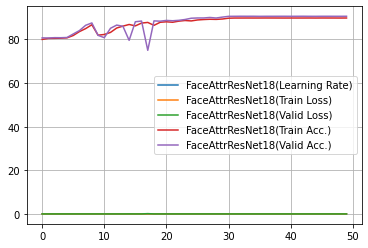

In [20]:
# config.epoch = 1
model = create_model(device)
dataloaders, attribute_names  = load_dataloaders()
criterion = get_criterion()
optimizer = get_optimizer(model)

print(f"=> Training model: {not config.evaluate}")
if config.evaluate:
    best_prec1, mtimer, _, _, _, = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.checkpoint_fname) # checkpoint_fname bestmodel_fname
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print_attribute_acc(top1, attribute_names)
else:
    best_prec1, mtimer, lr, start_epoch, logger = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.ckp_resume)
    run_name, run_time = get_run_name_time(model, criterion, optimizer, comments)
    mtimer = trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name, mtimer)

print(f"=> Model trained time: {mtimer}")

## Testing Loop

In [21]:
if not config.evaluate:
    config.evaluate = True
    model = create_model(device)
    dataloaders, attribute_names = load_dataloaders()
    criterion = get_criterion()
    optimizer = get_optimizer(model)

    best_prec1, mtimer, _, _, _, = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.bestmodel_fname)# config.bestmodel_fname  config.checkpoint_fname
    #print(model)
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print(f"=> Model trained time: {mtimer}")
    print_attribute_acc(top1, attribute_names)

=> creating model 'FaceAttrResNet'
Dataset sizes: {'test': 19962}
Class Labels: 40
=> resuming model: checkpoints\model_best.pth.tar
=> loading checkpoint 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/156 [00:00<?, ?it/s]

=> loaded checkpoint 'checkpoints\model_best.pth.tar' (epoch 33)


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.97it/s]

(156/156) Data: 0.052s | Batch: 0.165s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.0019 | top1:  89.9999
=> Best test accuracy: 89.99987474280431, Model val acc: 90.63761513817981
=> Model trained time: 03:12:00
5_o_Clock_Shadow: 93.09187454561494
Arched_Eyebrows: 80.33263198704248
Attractive: 80.34766055964096
Bags_Under_Eyes: 82.72718161607885
Bald: 98.64242056168317
Bangs: 95.3762147859681
Big_Lips: 69.72247268666057
Big_Nose: 82.32642016015733
Black_Hair: 89.00410780406479
Blond_Hair: 95.59162405748046
Blurry: 95.00050092352593
Brown_Hair: 88.06231840420504
Bushy_Eyebrows: 91.58400960528006
Chubby: 95.09568176712878
Double_Chin: 95.85211898869449
Eyeglasses: 99.20849614572865
Goatee: 96.56347058113418
Gray_Hair: 97.9911832137739
Heavy_Makeup: 90.00601141787928
High_Cheekbones: 86.53942488439216
Male: 97.37501248634001
Mouth_Slightly_Open: 92.14006609735621
Mustache: 96.13265200753379
Narrow_Eyes: 85.58761644224857
No_Beard: 94.65484416958995
Oval_Face: 74.03065821780744
Pale_Skin: 96

## Save & Backup

In [22]:
# Wait for notebook to save
%autosave 1
time.sleep(150)
%autosave 120

Autosaving every 1 seconds


Autosaving every 120 seconds


In [23]:
def backup_everything(run_time, run_name, title):
    # backup checkpoints
    run_dir = os.path.join(config.BACKUP_DIR, run_name, run_time)
    create_dir_ifne(run_dir)
    fromDirectory = config.CHECKPOINT_DIR
    toDirectory = run_dir
    copy_tree(fromDirectory, toDirectory)
    # backup notebook html
    nb_name = title + '.ipynb'
    html_name = title + '.html'
    save_name = os.path.join(run_dir, html_name)
    !jupyter nbconvert --to html $nb_name
    !move $html_name $save_name
    
backup_everything(run_time, run_name, title)

[NbConvertApp] Converting notebook ai6126-project1-colab-v0.91.ipynb to html
[NbConvertApp] Writing 988718 bytes to ai6126-project1-colab-v0.91.html

        1 file(s) moved.

In [24]:
if config.auto_hibernate and False:
    os.system('shutdown -h')